In [13]:
# Import required packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import ImageFolder
import os

print("✅ Packages imported successfully!")

✅ Packages imported successfully!


In [20]:
# Create data directory and set dataset path
data_dir = './data'
os.makedirs(data_dir, exist_ok=True)

fruits_path = os.path.join(data_dir, 'fruits-360_100x100', 'fruits-360')
fruits_training_path = os.path.join(fruits_path, 'Training')

print(f"Current working directory: {os.getcwd()}")
print(f"Data directory: {os.path.abspath(data_dir)}")

# Check if dataset exists, if not download it
if os.path.exists(fruits_training_path):
    print(f"✓ Found existing dataset at: {os.path.abspath(fruits_path)}")
else:
    print("Fruits 360 dataset not found. Downloading via Kaggle API...")
    print("This may take several minutes (dataset is ~800MB)...\n")
    
    try:
        import kaggle
        kaggle.api.dataset_download_files('moltean/fruits', path=data_dir, unzip=True)
        print("\n✓ Download complete!")
        
        # Check if the dataset was extracted to the expected location
        if os.path.exists(fruits_training_path):
            print(f"✓ Dataset found at: {os.path.abspath(fruits_path)}")
        else:
            print("⚠️  Dataset downloaded but not found at expected location.")
            print("Please check the extracted folder structure.")
            # List what was actually downloaded
            if os.path.exists(data_dir):
                print(f"Contents of {data_dir}:")
                for item in os.listdir(data_dir):
                    print(f"  - {item}")
    except Exception as e:
        print(f"✗ Download failed: {e}")
        print("Please ensure Kaggle API is configured.")

# Display dataset info
if os.path.exists(fruits_training_path):
    classes = [c for c in os.listdir(fruits_training_path) 
               if os.path.isdir(os.path.join(fruits_training_path, c))]
    print(f"\n✓ {len(classes)} fruit classes available")
    
    # Show Apple varieties
    apple_varieties = [f for f in classes if 'Apple' in f or 'apple' in f]
    if apple_varieties:
        print(f"\nApple varieties found ({len(apple_varieties)}):")
        for i, fruit in enumerate(apple_varieties, 1):
            num_imgs = len(os.listdir(os.path.join(fruits_training_path, fruit)))
            print(f"  {i}. '{fruit}' ({num_imgs} images)")

Current working directory: /Users/oleh/Documents/cv_homeworks/real_nvp
Data directory: /Users/oleh/Documents/cv_homeworks/real_nvp/data
Fruits 360 dataset not found. Downloading via Kaggle API...
This may take several minutes (dataset is ~800MB)...

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits

✓ Download complete!
✓ Dataset found at: /Users/oleh/Documents/cv_homeworks/real_nvp/data/fruits-360_100x100/fruits-360

✓ 225 fruit classes available

Apple varieties found (32):
  1. 'Apple 12' (466 images)
  2. 'Apple 5' (440 images)
  3. 'Pineapple 1' (490 images)
  4. 'Apple Granny Smith 1' (492 images)
  5. 'Apple 13' (699 images)
  6. 'Apple 14' (466 images)
  7. 'Apple Braeburn 1' (492 images)
  8. 'Apple Golden 2' (492 images)
  9. 'Apple Red 1' (492 images)
  10. 'Apple Golden 3' (481 images)
  11. 'Apple Rotten 1' (488 images)
  12. 'Apple Red Yellow 1' (492 images)
  13. 'Apple Pink Lady 1' (456 images)
  14. 'Apple Core 1' (470 images)
  15. 'Pineapple Mini 1' (493 im

In [21]:
# Select apple variety and prepare data loaders
selected_fruit = 'Apple Red 1'  # Change to your preferred apple variety

print(f"Selected fruit: {selected_fruit}\n")

# Define transforms - flatten to 1D for RealNVP
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to 1D (32*32*3 = 3072)
])

# Load dataset
if os.path.exists(fruits_training_path):
    # Load all fruits first
    temp_dataset = ImageFolder(root=fruits_training_path, transform=transform)
    
    if selected_fruit in temp_dataset.classes:
        class_idx = temp_dataset.class_to_idx[selected_fruit]
        indices = [i for i, (path, label) in enumerate(temp_dataset.samples) if label == class_idx]
        full_dataset = Subset(temp_dataset, indices)
        
        print(f"✓ Found {len(full_dataset)} images of {selected_fruit}")
        
        # Split into train and test (80/20)
        train_size = int(0.8 * len(full_dataset))
        test_size = len(full_dataset) - train_size
        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
        
        print(f"Training: {train_size} images")
        print(f"Testing: {test_size} images")
    else:
        print(f"✗ '{selected_fruit}' not found in dataset!")
else:
    print("✗ Dataset not found!")

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\n✓ Data loaders created with batch size: {batch_size}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Testing batches: {len(test_loader)}")

Selected fruit: Apple Red 1

✓ Found 492 images of Apple Red 1
Training: 393 images
Testing: 99 images

✓ Data loaders created with batch size: 64
  Training batches: 7
  Testing batches: 2


## 3. Define RealNVP Model

Implement the coupling layers and RealNVP architecture.

In [22]:
# Define CouplingLayer and RealNVP classes
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask):
        super().__init__()
        self.mask = mask
        # Networks for scale (s) and translation (t)
        self.s_fc = nn.Linear(input_dim, output_dim)
        self.t_fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        x_m = x * self.mask
        s_out = torch.tanh(self.s_fc(x_m))
        t_out = self.t_fc(x_m)
        # Full affine transformation (restored)
        y = x_m + (1 - self.mask) * (x * torch.exp(s_out) + t_out)

        log_det_jacobian = s_out.sum(dim=1)
        return y, log_det_jacobian
    
    def backward(self, y):
        y_m = y * self.mask
        s_out = torch.tanh(self.s_fc(y_m))
        t_out = self.t_fc(y_m)
        x = y_m + (1 - self.mask) * (y - t_out) * torch.exp(-s_out)
        return x

class RealNVP(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, 'Number of coupling layers should be >= 2'
        self.modules_list = []
        self.modules_list.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        for _ in range(n_layers - 2):
            mask = 1 - mask
            self.modules_list.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        self.modules_list.append(CouplingLayer(input_dim, output_dim, hid_dim, 1 - mask))
        self.module_list = nn.ModuleList(self.modules_list)
    
    def forward(self, x):
        ldj_sum = 0
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum
    
    def backward(self, z):
        for module in reversed(self.module_list):
            z = module.backward(z)
        return z

print("✅ RealNVP and CouplingLayer classes defined!")
print("⚠️  Restored full affine transformation for better learning")

✅ RealNVP and CouplingLayer classes defined!
⚠️  Restored full affine transformation for better learning


In [23]:
# Setup model, optimizer, and prior
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if not torch.backends.mps.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For RGB images 32x32: 32*32*3 = 3072 dimensions
input_dim = 32 * 32 * 3
output_dim = 32 * 32 * 3
hid_dim = 512
n_layers = 6

# Create checkerboard-like mask
mask = torch.zeros(input_dim)
ones = 8
zeros = 7
step = ones + zeros
for i in range(0, input_dim, step):
    mask[i:i+ones] = 1
mask = mask.to(device)

# Initialize model
model = RealNVP(input_dim, output_dim, hid_dim, mask, n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Prior distribution (standard Gaussian)
prior = torch.distributions.MultivariateNormal(
    torch.zeros(input_dim).to(device), 
    torch.eye(input_dim).to(device)
)

total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Model initialized on {device}")
print(f"Total parameters: {total_params:,}")
print(f"Input dimension: {input_dim} (32x32x3 RGB image flattened)")

✅ Model initialized on mps
Total parameters: 113,283,072
Input dimension: 3072 (32x32x3 RGB image flattened)


## 4. Define Training and Evaluation Functions

In [24]:
# Training function
def train_realnvp(model, train_loader, optimizer, prior, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        z, log_det_jacobian = model(data)
        log_pz = prior.log_prob(z)
        loss = -torch.mean(log_pz + log_det_jacobian)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

# Evaluation function
def eval_realnvp(model, test_loader, prior, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            z, log_det_jacobian = model(data)
            log_pz = prior.log_prob(z)
            loss = -torch.mean(log_pz + log_det_jacobian)
            test_loss += loss.item()
    return test_loss / len(test_loader)

print("✅ Training and evaluation functions defined!")

✅ Training and evaluation functions defined!


## 5. Train the Model

In [25]:
# Training loop
print(f"Training RealNVP on {selected_fruit}")
print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}\n")
print("="*70)

num_epochs = 10  # Adjust as needed
train_losses = []
test_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_realnvp(model, train_loader, optimizer, prior, device)
    train_losses.append(train_loss)
    
    test_loss = eval_realnvp(model, test_loader, prior, device)
    test_losses.append(test_loss)
    
    print(f"Epoch {epoch:02d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Test Loss: {test_loss:.4f}")
    
    # Save best model
    if epoch == 1 or test_loss == min(test_losses):
        best_epoch = epoch
        torch.save(model.state_dict(), 'realnvp_fruits_best.pth')
        print(f"  → Saved best model")

print("="*70)
print(f"\n✅ Training complete!")
print(f"Best model from epoch {best_epoch} with test loss: {min(test_losses):.4f}")

Training RealNVP on Apple Red 1
Training samples: 393, Test samples: 99

Epoch 01/10 | Train Loss: 186.0052 | Test Loss: -4534.0208
  → Saved best model
Epoch 02/10 | Train Loss: -6874.4544 | Test Loss: -8986.2988
  → Saved best model
Epoch 03/10 | Train Loss: -9805.5379 | Test Loss: -10504.9326
  → Saved best model
Epoch 04/10 | Train Loss: -10877.9976 | Test Loss: -11273.8584
  → Saved best model
Epoch 05/10 | Train Loss: -11495.3880 | Test Loss: -11719.1436
  → Saved best model
Epoch 06/10 | Train Loss: -11933.9657 | Test Loss: -12089.8330
  → Saved best model
Epoch 07/10 | Train Loss: -12159.8265 | Test Loss: -12171.5928
  → Saved best model
Epoch 08/10 | Train Loss: -12396.0480 | Test Loss: -12549.2983
  → Saved best model
Epoch 09/10 | Train Loss: -12635.1631 | Test Loss: -12645.2144
  → Saved best model
Epoch 10/10 | Train Loss: -12795.8071 | Test Loss: -12798.8203
  → Saved best model

✅ Training complete!
Best model from epoch 10 with test loss: -12798.8203


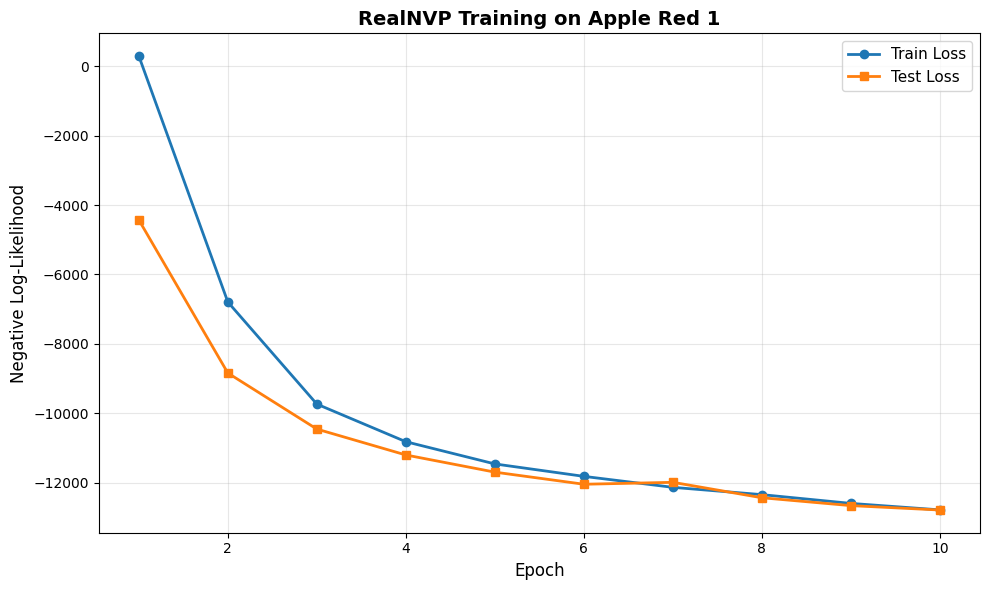

Final Train Loss: -12785.8917
Final Test Loss: -12789.6694


In [ ]:
# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o', linewidth=2)
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='s', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Negative Log-Likelihood', fontsize=12)
plt.title(f'RealNVP Training on {selected_fruit}', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")

## 6. Demonstrate Invertibility Property

Show that RealNVP can transform images to latent space and reconstruct them back.

Reconstruction MSE error: 0.000000


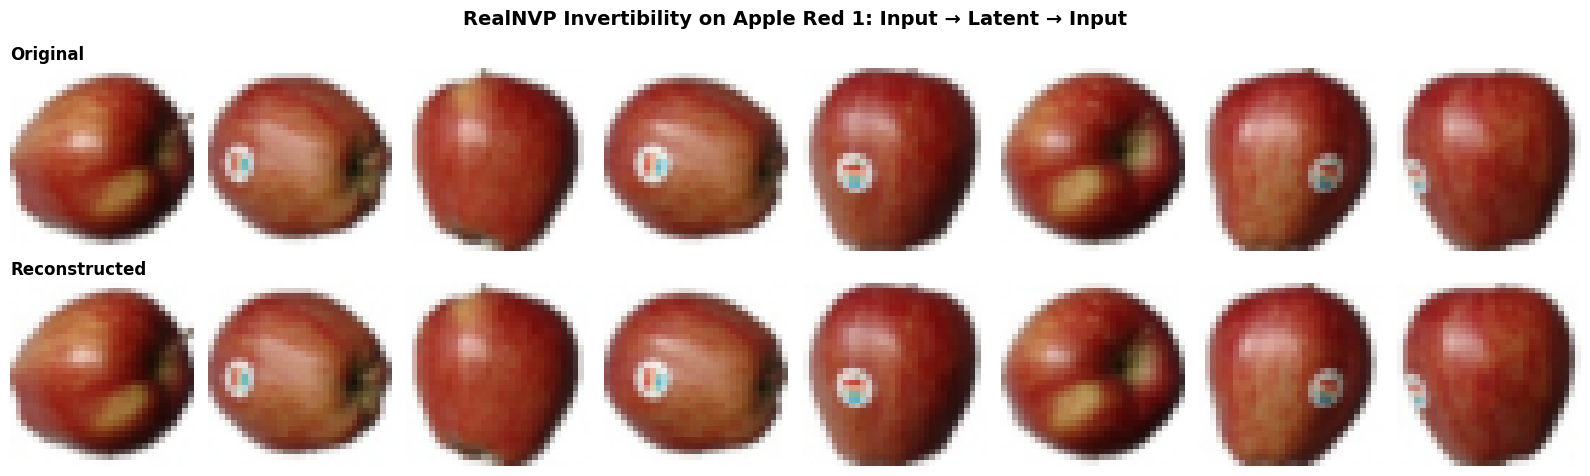

In [26]:
# Demonstrate RealNVP invertibility: input -> latent -> input (reconstruction)
model.eval()
batch_flat = next(iter(train_loader))[0][:8].to(device)  # Take 8 images (already flattened)

with torch.no_grad():
    z, _ = model(batch_flat)
    x_recon = model.backward(z)

recon_error = F.mse_loss(x_recon, batch_flat).item()
print(f"Reconstruction MSE error: {recon_error:.6f}")

# Visualize
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
for i in range(8):
    # Reshape from flat (3072,) to image (3, 32, 32) then permute to (32, 32, 3)
    orig_img = batch_flat[i].cpu().view(3, 32, 32).permute(1, 2, 0)
    recon_img = x_recon[i].cpu().view(3, 32, 32).permute(1, 2, 0)
    
    # Clamp to [0, 1] for display
    orig_img = torch.clamp(orig_img, 0, 1)
    recon_img = torch.clamp(recon_img, 0, 1)
    
    axes[0, i].imshow(orig_img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=12, fontweight='bold', loc='left')
    
    axes[1, i].imshow(recon_img)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed', fontsize=12, fontweight='bold', loc='left')

plt.suptitle(f'RealNVP Invertibility on {selected_fruit}: Input → Latent → Input', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

✓ Found 166 Pineapple 1 images
✓ Created data loader with 21 batches
Reconstruction MSE error on Pineapple 1: 0.000000


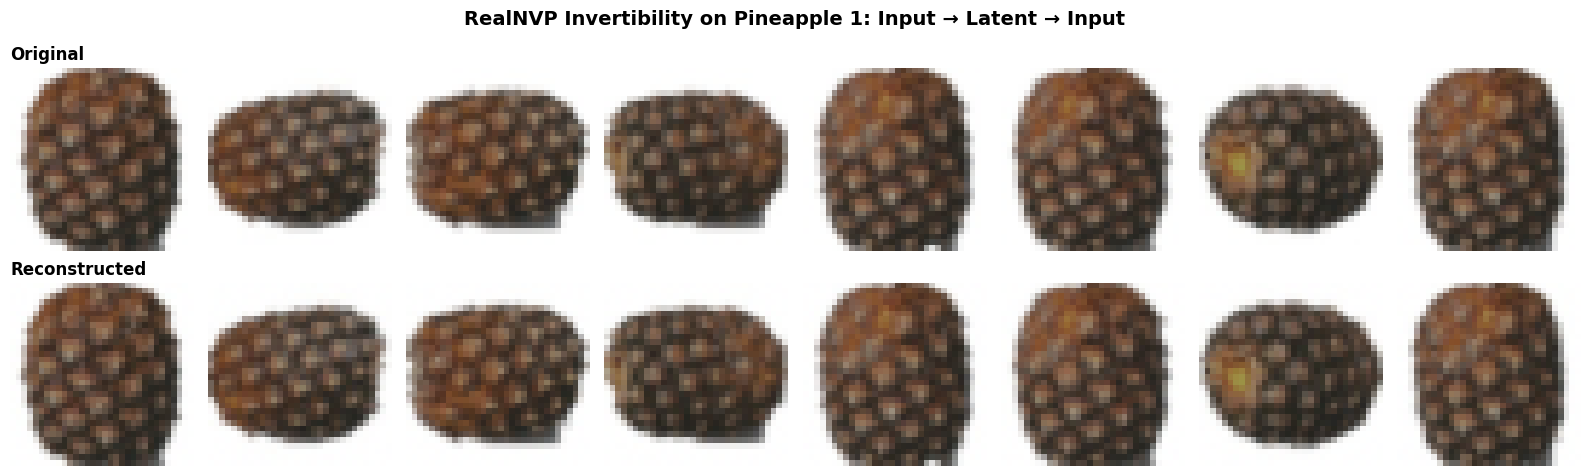

In [28]:
# Load Pineapple 1 dataset from the specified path
pineapple_path = './data/fruits-360_100x100/fruits-360/Test'

# Define the same transforms used for training
pineapple_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 (same as training)
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to 1D (32*32*3 = 3072)
])

# Load the pineapple dataset
if os.path.exists(pineapple_path):
    pineapple_dataset = ImageFolder(root=pineapple_path, transform=pineapple_transform)
    
    if 'Pineapple 1' in pineapple_dataset.class_to_idx:
        pineapple_class_idx = pineapple_dataset.class_to_idx['Pineapple 1']
        pineapple_indices = [i for i, (_, label) in enumerate(pineapple_dataset.samples) if label == pineapple_class_idx]
        pineapple_subset = Subset(pineapple_dataset, pineapple_indices)
        
        # Create a data loader for pineapple images
        pineapple_loader = DataLoader(pineapple_subset, batch_size=8, shuffle=True, num_workers=0)
        
        print(f"✓ Found {len(pineapple_subset)} Pineapple 1 images")
        print(f"✓ Created data loader with {len(pineapple_loader)} batches")
    else:
        print("✗ 'Pineapple 1' not found in dataset!")
else:
    print(f"✗ Dataset path does not exist: {pineapple_path}")

# Demonstrate RealNVP invertibility on Pineapple 1: input -> latent -> input (reconstruction)
model.eval()
batch_flat = next(iter(pineapple_loader))[0][:8].to(device)  # Take 8 pineapple images (already flattened)

with torch.no_grad():
    z, _ = model(batch_flat)
    x_recon = model.backward(z)

recon_error = F.mse_loss(x_recon, batch_flat).item()
print(f"Reconstruction MSE error on Pineapple 1: {recon_error:.6f}")

# Visualize
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
for i in range(8):
    # Reshape from flat (3072,) to image (3, 32, 32) then permute to (32, 32, 3)
    orig_img = batch_flat[i].cpu().view(3, 32, 32).permute(1, 2, 0)
    recon_img = x_recon[i].cpu().view(3, 32, 32).permute(1, 2, 0)
    
    # Clamp to [0, 1] for display
    orig_img = torch.clamp(orig_img, 0, 1)
    recon_img = torch.clamp(recon_img, 0, 1)
    
    axes[0, i].imshow(orig_img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=12, fontweight='bold', loc='left')
    
    axes[1, i].imshow(recon_img)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed', fontsize=12, fontweight='bold', loc='left')

plt.suptitle('RealNVP Invertibility on Pineapple 1: Input → Latent → Input', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()